<a href="https://colab.research.google.com/github/MoKaif/Sentiment_Analysis_Of_Restaurant_Reviews/blob/main/Sentiment_Analysis_Of_Restaurant_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Restaurant Reviews

In this project, we perform sentiment analysis on a dataset of restaurant reviews. The goal is to classify each review as either positive or negative sentiment. We'll follow these steps:


## Importing Necessary Libraries

We start by importing essential libraries required for data preprocessing, model building, and evaluation. These include pandas, numpy, NLTK (Natural Language Toolkit), scikit-learn, CatBoost, and TensorFlow.

In [57]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


## Loading the Dataset

We load the restaurant reviews dataset from a TSV (Tab-Separated Values) file. The dataset contains two columns: 'Review' and 'Liked.' 'Review' contains the text of the reviews, and 'Liked' indicates whether the review is positive (1) or negative (0) sentiment.

In [58]:
# Load your restaurant reviews dataset
df = pd.read_csv('/content/Restaurant_Reviews.tsv', delimiter='\t')

### 1. Text Preprocessing

We perform various text preprocessing steps on the reviews:
   - Remove special characters and numbers using regular expressions.
   - Convert text to lowercase.
   - Tokenize the text into words.
   - Remove stopwords (common words like "the," "and," etc.).
   - Apply stemming to reduce words to their root form using the Porter Stemmer algorithm.

   
 ### 2. Create Separate Corpora

We create separate corpora for positive and negative words based on the sentiment in the reviews. This is done to analyze word frequencies later.

In [59]:
# Data Preprocessing
nltk.download('stopwords')
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Create separate corpora for positive and negative words
positive_corpus = []
negative_corpus = []

def preprocess_text(text):
    # Remove special characters and numbers using regular expressions
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Convert to lowercase and tokenize
    words = nltk.word_tokenize(text.lower())

    # Remove stopwords and apply stemming
    words = [stemmer.stem(word) for word in words if word not in stop_words]

    # Add words to the corresponding corpus based on sentiment
    if 'posit' in text:
        positive_corpus.extend(words)
    elif 'negat' in text:
        negative_corpus.extend(words)

    return ' '.join(words)

df['Processed_Review'] = df['Review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Splitting

We split the preprocessed data into training and testing sets using scikit-learn's `train_test_split` function. Typically, 80% of the data is used for training, and 20% for testing.

In [60]:
# Split data into training and testing sets
X = df['Processed_Review'].values
y = df['Liked'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Vectorize Text Data

We use TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to convert the text data into numerical features. This step transforms the text into a format suitable for machine learning models. We use scikit-learn's `TfidfVectorizer` for this purpose.

In [61]:
# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Tokenize and pad the text data for LSTM
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
max_sequence_length = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

## Model Building and Training

### 4. Support Vector Machine (SVM)

We build an SVM (Support Vector Machine) classifier using scikit-learn's `SVC` class with a linear kernel. We train the SVM model on the TF-IDF vectorized data and make predictions on both training and testing datasets.

### 5. CatBoost Classifier

We build a CatBoost classifier using the CatBoost library. The classifier is trained on the TF-IDF vectorized data, and we make predictions on both training and testing datasets.

### 6. LSTM (Long Short-Term Memory) Neural Network

We build an LSTM neural network using TensorFlow's Keras API for text classification. The LSTM model is trained on tokenized and padded text sequences. We specify an embedding layer, LSTM layer, and a dense output layer with sigmoid activation. The model is compiled and trained with binary cross-entropy loss and accuracy metrics.

In [62]:
# Build and train the models
# Model 1: Support Vector Machine (SVM)
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)
svm_train_predictions = svm_classifier.predict(X_train_tfidf)
svm_test_predictions = svm_classifier.predict(X_test_tfidf)

# Model 2: CatBoost Classifier
catboost_classifier = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
catboost_classifier.fit(X_train_tfidf, y_train)
catboost_train_predictions = catboost_classifier.predict(X_train_tfidf)
catboost_test_predictions = catboost_classifier.predict(X_test_tfidf)

# Model 3: LSTM
lstm_model = Sequential()
lstm_model.add(Embedding(10000, 128, input_length=max_sequence_length))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_padded, y_train, epochs=5, batch_size=32)
lstm_train_predictions = (lstm_model.predict(X_train_padded) > 0.5).astype(int)
lstm_test_predictions = (lstm_model.predict(X_test_padded) > 0.5).astype(int)

# Calculate and display the accuracies
svm_train_accuracy = accuracy_score(y_train, svm_train_predictions)
svm_test_accuracy = accuracy_score(y_test, svm_test_predictions)
catboost_train_accuracy = accuracy_score(y_train, catboost_train_predictions)
catboost_test_accuracy = accuracy_score(y_test, catboost_test_predictions)
lstm_train_accuracy = accuracy_score(y_train, lstm_train_predictions)
lstm_test_accuracy = accuracy_score(y_test, lstm_test_predictions)

print("Training Accuracy:")
print(f"SVM: {svm_train_accuracy:.4f}")
print(f"CatBoost: {catboost_train_accuracy:.4f}")
print(f"LSTM: {lstm_train_accuracy:.4f}")
print("\nTesting Accuracy:")
print(f"SVM: {svm_test_accuracy:.4f}")
print(f"CatBoost: {catboost_test_accuracy:.4f}")
print(f"LSTM: {lstm_test_accuracy:.4f}")


Epoch 1/5
25/25 [==============================] - 2s 16ms/step - loss: 0.6940 - accuracy: 0.5075
Epoch 2/5
25/25 [==============================] - 0s 16ms/step - loss: 0.6394 - accuracy: 0.6575
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 0.3084 - accuracy: 0.8913
Epoch 4/5
25/25 [==============================] - 1s 20ms/step - loss: 0.1608 - accuracy: 0.9425
Epoch 5/5
7/7 [==============================] - 1s 5ms/step
Training Accuracy:
SVM: 0.9600
CatBoost: 0.8562
LSTM: 0.9925

Testing Accuracy:
SVM: 0.7500
CatBoost: 0.7050
LSTM: 0.7350


## Model Evaluation

We calculate and display the training and testing accuracies for all three models: SVM, CatBoost, and LSTM. Accuracy measures the proportion of correctly classified samples.

---

This code provides a comprehensive example of how to perform sentiment analysis on restaurant reviews using different models and demonstrates text preprocessing, data splitting, vectorization, and model building steps.



Testing F1 Score:
SVM: 0.7423
CatBoost: 0.6590
LSTM: 0.7337


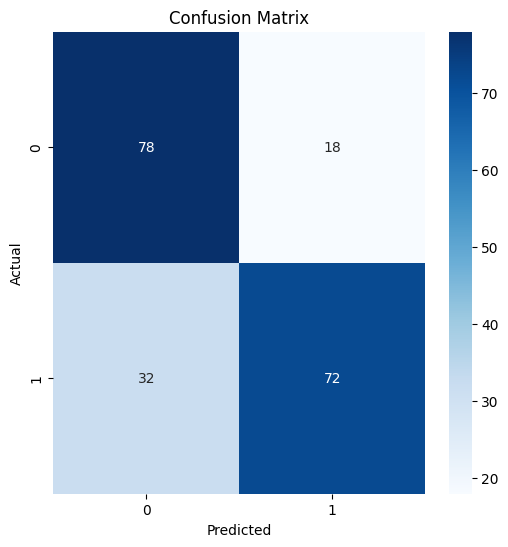

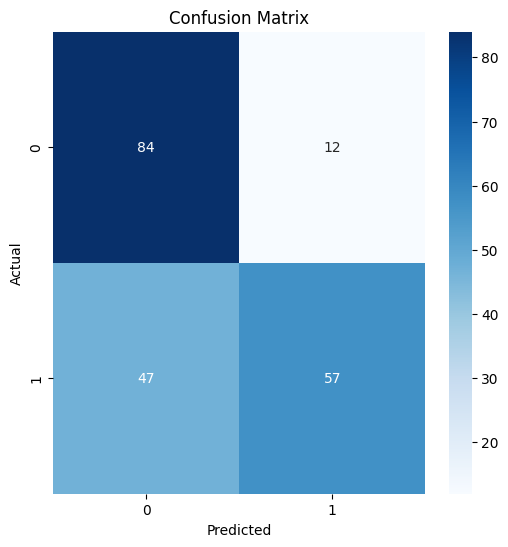

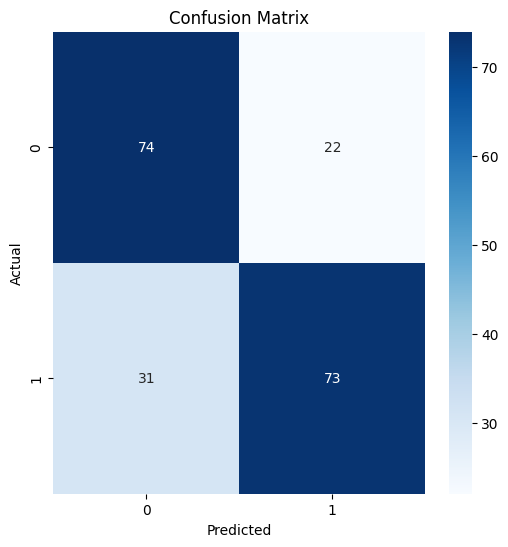

In [63]:
# Calculate and display the F1 scores
svm_f1 = f1_score(y_test, svm_test_predictions)
catboost_f1 = f1_score(y_test, catboost_test_predictions)
lstm_f1 = f1_score(y_test, lstm_test_predictions)

print("\nTesting F1 Score:")
print(f"SVM: {svm_f1:.4f}")
print(f"CatBoost: {catboost_f1:.4f}")
print(f"LSTM: {lstm_f1:.4f}")

# Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_test, svm_test_predictions, labels=[0, 1])
plot_confusion_matrix(y_test, catboost_test_predictions, labels=[0, 1])
plot_confusion_matrix(y_test, lstm_test_predictions, labels=[0, 1])